# Deep Learning (End to End) Potato Disease Classification Model

A guided CodeBasics Deep Learning Project where a Convolutional Model is deployed onto a Website (FastAPI) and Mobile App (React Native, Google Cloud). Its purpose is the classification of potato plant images into "healthy", "Early Blight" and "Late Blight" categories.

This notebook is primarily concerned with the data ETL ("Extract, Transform, Load") process and Model building/training.

In [1]:
#Importing Libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from matplotlib import image

In [2]:
#Defining constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [3]:
#Loading Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
#Fetching class names and number of classes
class_names = dataset.class_names
n_classes = len(class_names)

In [5]:
#Checking length of dataset
print("Dataset Length: ", len(dataset))

Dataset Length:  68


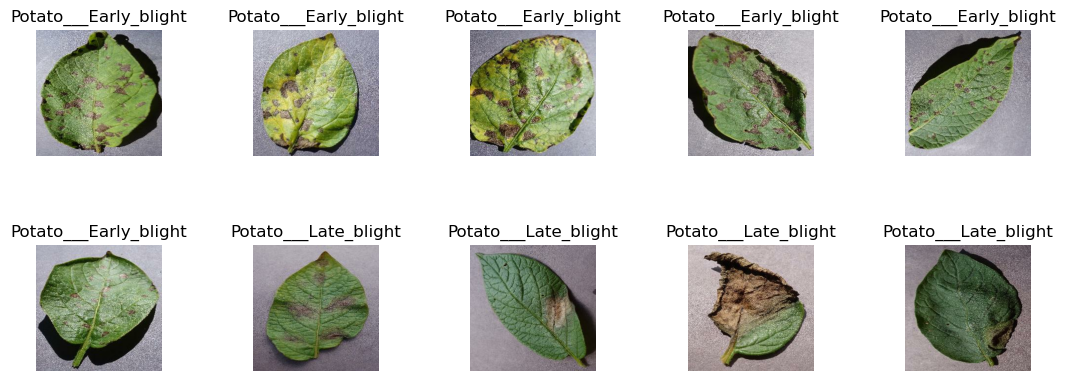

In [6]:
#Displaying image samples
for image_batch, label_batch in dataset.take(1):
    fig = plt.figure(figsize=(12,5))
    #print(image_batch.shape)
    #print(label_batch.shape)
    for i in range(1,11):
        ax = plt.subplot(2,5,i)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        plt.tight_layout(pad=5)
plt.savefig("images/samples.png")

### Splitting Data

In [7]:
#Splitting data into 80% training, 10% cross-valdiation, 10% test
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size) 

    return train_ds, val_ds, test_ds

In [8]:
#Executing partitioning function
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [9]:
#Setting up input pipeline optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
#Resize and Rescale layers
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [11]:
#Data Augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [12]:
#Constructing Convolutional Model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #tf.keras.Input(shape=input_shape),#, batch_size=BATCH_SIZE),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [13]:
#Compiling Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint("models/model1.keras", verbose=1, save_best_only=1)
            ]

In [14]:
#Training Model using GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        epochs=100, 
        batch_size=BATCH_SIZE, 
        verbose=1, 
        validation_data=val_ds,
        callbacks=callbacks)

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.9154 - accuracy: 0.4757
Epoch 1: val_loss improved from inf to 0.94570, saving model to models\model1.keras
54/54 [==============================] - 15s 159ms/step - loss: 0.9154 - accuracy: 0.4757 - val_loss: 0.9457 - val_accuracy: 0.4554
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 0.7143 - accuracy: 0.6655
Epoch 2: val_loss improved from 0.94570 to 0.72013, saving model to models\model1.keras
54/54 [==============================] - 9s 159ms/step - loss: 0.7143 - accuracy: 0.6655 - val_loss: 0.7201 - val_accuracy: 0.7153
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8287
Epoch 3: val_loss improved from 0.72013 to 0.58582, saving model to models\model1.keras
54/54 [==============================] - 9s 159ms/step - loss: 0.4219 - accuracy: 0.8287 - val_loss: 0.5858 - val_accuracy: 0.7517
Epoch 4/100
54/54 [==============================] - ETA: 0s 

In [15]:
#Saving first model
tf.keras.models.save_model(model, "models/model1.keras")

In [16]:
#Converting training log into Pandas dataframe
history_df = pd.DataFrame(history.history)

<Figure size 1000x700 with 0 Axes>

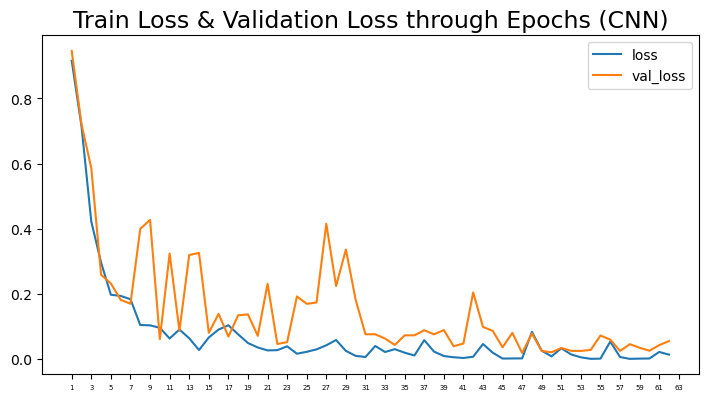

In [18]:
#Plotting loss through different epochs
fig = plt.figure(figsize=(10,7))
(history_df[['loss', 'val_loss']]).plot(figsize=(8,5))
plt.title("Train Loss & Validation Loss through Epochs (CNN)", fontsize=17)
plt.tight_layout(pad=4)
ticks = np.arange(0,63,2)
plt.xticks(ticks=ticks, labels=[i+1 for i in ticks], fontsize=5)
plt.savefig("images/Loss_Val_Loss_CNN.png", bbox_inches="tight")
plt.show()

<Figure size 1000x700 with 0 Axes>

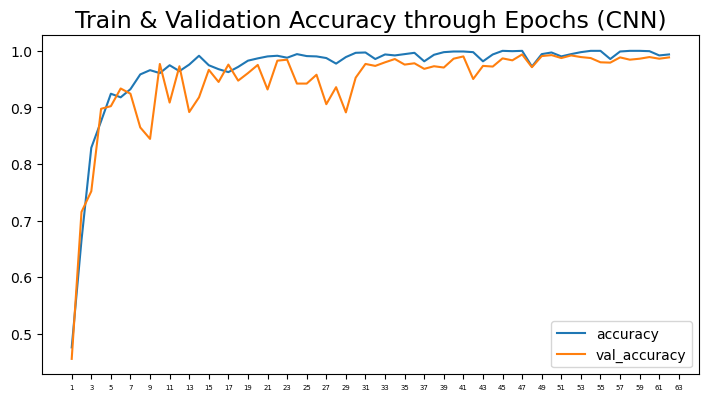

In [19]:
#Plotting accuracy through different epochs
fig = plt.figure(figsize=(10,7))
(history_df[['accuracy', 'val_accuracy']]).plot(figsize=(8,5))
plt.title("Train & Validation Accuracy through Epochs (CNN)", fontsize=17)
plt.tight_layout(pad=4)
ticks = np.arange(0,63,2)
plt.xticks(ticks=ticks, labels=[i+1 for i in ticks], fontsize=5)
plt.savefig("images/Acc_Val_Acc_CNN.png", bbox_inches="tight")
plt.show()

In [20]:
#Defining predict function for different batches
def predict(images_batch, model, class_names=class_names):
    
    predictions = model.predict(images_batch)
    predicted_classes = np.array([class_names[np.argmax(i)] for i in predictions])
    confidences = np.array([round(np.max(i), 2) for i in predictions])

    return predicted_classes, confidences 

### Test Set

In [24]:
#Evaluating Model on test set
model.evaluate(test_ds)

54/54 [==============================] - 1s 24ms/step - loss: 0.0187 - accuracy: 0.9936


[0.018661770969629288, 0.9936342835426331]

### Visualizing Results

1/1 [==============================] - 0s 32ms/step


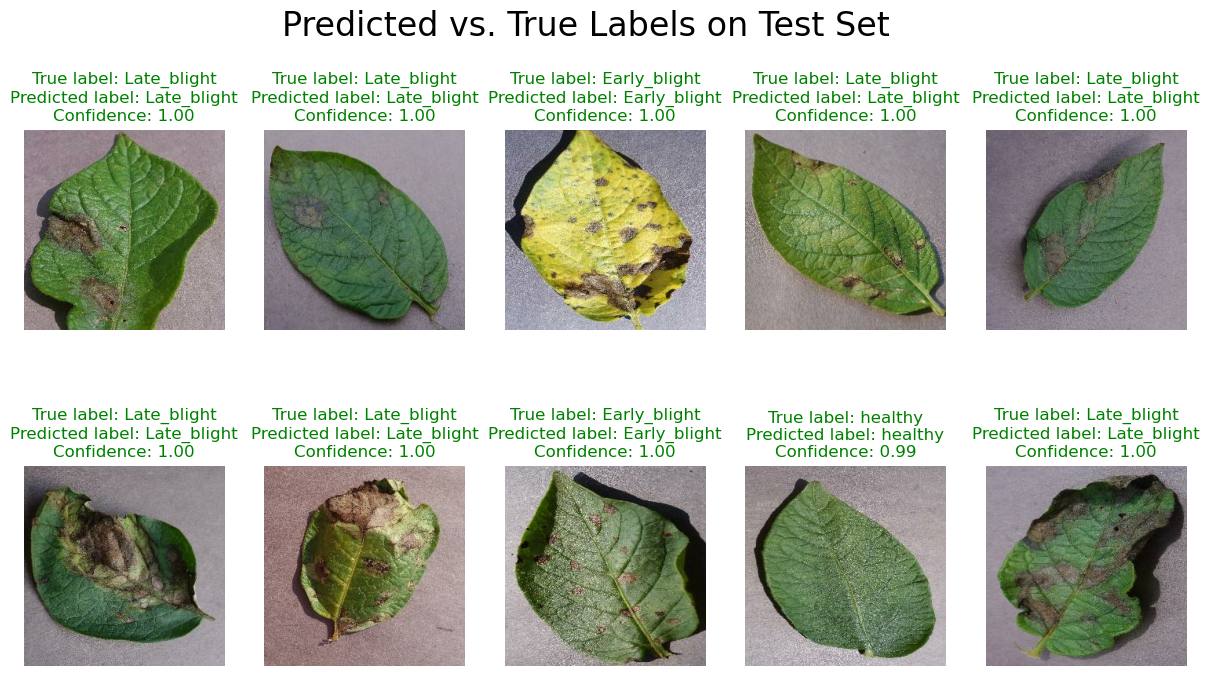

In [51]:
#Taking one batch of images and labels
for images_batch, labels_batch in test_ds.take(1):
    predicted_labels, confidences = predict(images_batch.numpy(), model)
    fig = plt.figure(figsize=(15,8))
    plt.suptitle("Predicted vs. True Labels on Test Set", fontsize=24)
    #Iterating through images and labels inside of one batch
    for i in range(10):
        image = (images_batch[i].numpy().astype('uint8'))
        true_label = class_names[labels_batch[i].numpy()]
        predicted_label = predicted_labels[i]
        confidence = confidences[i]

        #Plotting results
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        #plt.tight_layout()
        col = "green" if predicted_label==true_label else "red"
        plt.title(f'True label: {true_label.split("___")[1]}\nPredicted label: {predicted_label.split("___")[1]}\nConfidence: {confidence:.2f}', color=col)
plt.savefig("images/Test_Set.png", bbox_inches="tight")

### Saving Model

In [53]:
#Saving model (incrementing versions)
model_version = max([int(os.listdir("models")[i].split(".")[0].split("l")[1]) for i in range (len(os.listdir("models")))])
new_model_version = model_version + 1
tf.keras.models.save_model(model, f"models/model{new_model_version}.keras")